<a href="https://colab.research.google.com/github/MarinaChau/F1-Hackathon-2022/blob/main/WeatherForecast_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Only with gooogle colab
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1) Load and preprocess dataset

In [11]:
%cd "/content/drive/MyDrive/WeatherForecast/"

/content/drive/MyDrive/WeatherForecast


In [12]:
# Standard libraries
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

sys.path.append("/content/drive/MyDrive/WeatherForecast/")

## ThirdParty libraries
import preprocessing_dataset



    

In [205]:
filepath = '/content/drive/MyDrive/WeatherForecast/weather_json.csv.zip'

with ZipFile(filepath, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
weather_json.csv                               2022-02-21 18:32:28    229494379
__MACOSX/._weather_json.csv                    2022-02-21 18:32:28          212
Extracting all the files now...
Done!


In [13]:
# Parameters
columns_to_drop = ["M_PLAYER_CAR_INDEX", "M_FRAME_IDENTIFIER", "M_SESSION_TIME", "GAMEHOST", "M_SECONDARY_PLAYER_CAR_INDEX", 
                   "M_PIT_STOP_WINDOW_IDEAL_LAP", "M_GAME_MINOR_VERSION", "M_GEARBOX_ASSIST", 
                   "M_SLI_PRO_NATIVE_SUPPORT", "M_SAFETY_CAR_STATUS",
                   "M_SEASON_LINK_IDENTIFIER", "M_PIT_ASSIST", "M_FORMULA", "M_WEEKEND_LINK_IDENTIFIER", 
                   "M_PIT_STOP_REJOIN_POSITION", "M_PIT_SPEED_LIMIT", "M_DYNAMIC_RACING_LINE",
                   "M_PIT_RELEASE_ASSIST", "M_PIT_STOP_WINDOW_LATEST_LAP", 
                   "M_PACKET_FORMAT", "M_GAME_MAJOR_VERSION", "M_PACKET_VERSION", 
                   "M_PACKET_ID", "M_AI_DIFFICULTY", 
                   "M_IS_SPECTATING", "M_DRSASSIST", "M_NUM_MARSHAL_ZONES", "M_STEERING_ASSIST",
                   "M_NETWORK_GAME","M_ERSASSIST","M_BRAKING_ASSIST","M_SPECTATOR_CAR_INDEX",
                   "M_DYNAMIC_RACING_LINE_TYPE", "UNNAMED: 0",
                   "M_TOTAL_LAPS"]


filepath_save = '/content/drive/MyDrive/WeatherForecast/dataset_reoganized_v8.pkl'
filepath_load = "/content/weather_json.csv"
cols_idx_groupby = "M_SESSION_LINK_IDENTIFIER"


In [ ]:
# Create instance of class PreprocessingDataset
prep = preprocessing_dataset.PreprocessDataset(filepath_load, filepath_save, columns_to_drop, cols_idx_groupby, zipped=False)
list_sessions_dataframe = prep.run_proprocessing()

In [109]:
list_sessions_dataframe[0].head()

,M_SESSION_LINK_IDENTIFIER,TIMESTAMP,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_GAME_PAUSED,M_FORECAST_ACCURACY,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,M_SESSION_TYPE,M_SESSION_TIME_LEFT,M_SESSION_DURATION,M_WEATHER,M_SESSION_UID,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_TRACK_TEMPERATURE_CHANGE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,TIME_SESSION
806404,18385973,1.643564e+09,33,4910,0,0,25,10,27,8,0,1080,0,6466960681235996680,8,0,2,2,1,1080
806405,18385973,1.643564e+09,33,4910,0,0,25,10,27,8,0,1080,0,6466960681235996680,8,5,2,2,1,1080
806406,18385973,1.643564e+09,33,4910,0,0,25,10,27,8,0,1080,0,6466960681235996680,8,10,2,2,1,1080
806401,18385973,1.643564e+09,33,4910,0,0,25,10,27,8,1,1080,0,6466960681235996680,8,0,2,2,1,1079
806402,18385973,1.643564e+09,33,4910,0,0,25,10,27,8,1,1080,0,6466960681235996680,8,5,2,2,1,1079


In [67]:
with open("dataset_reoganized_v8.pkl", 'rb') as handle:
    list_sessions_dataframe = pickle.load(handle)

# 2) Data Exploration

### Some stats



In [50]:
# Counts the items for each classes
# Weather - 0 = clear, 1 = light cloud, 2 = overcast
        # 3 = light rain, 4 = heavy rain, 5 = storm

weather_class_label = ["clear",
                 "light_cloud",
                 "overcast",
                 "light_rain",
                 "heavy_rain",
                 "storm"]

weather_class = {0:[],
                 1:[],
                 2:[],
                 3:[],
                 4:[],
                 5:[]}

for idx, df in enumerate(list_sessions_dataframe):
    i = len(df['M_WEATHER'].value_counts())
    for j in range(i):
        weather_class[j].append(df['M_WEATHER'].value_counts().iloc[j-1])

for i in range(6):
    weather_class[i] = sum(weather_class[i])

print("Counts of items per class:", weather_class)

for i in range(6):
    print(f"% of class {i}: {weather_class[i]/sum(weather_class.values()) * 100}")

Counts of items per class: {0: 376767, 1: 101197, 2: 28108, 3: 13216, 4: 4946, 5: 850}
% of class 0: 71.75366227117946
% of class 1: 19.272535441948335
% of class 2: 5.353048274180893
% of class 3: 2.516930624433424
% of class 4: 0.9419445269709228
% of class 5: 0.161878861286956


The dataset is very unbalanced towards class 0. 

In [51]:
best = 0  # Search for the longest shape
for idx, df in enumerate(list_sessions_dataframe):
    if best < df.shape[0]:
        best = df.shape[0]
        longest_df = idx
dataframe_eda = list_sessions_dataframe[longest_df]

### 1. Dropping not relevant columns to our model


In [55]:
for col in dataframe_eda.columns:
    if dataframe_eda[col].std() == 0:
        print(col)

dataframe_eda_new = dataframe_eda.drop(columns=["M_SESSION_LINK_IDENTIFIER",
"M_TRACK_LENGTH",
"M_GAME_PAUSED",
"M_FORECAST_ACCURACY",
"M_NUM_WEATHER_FORECAST_SAMPLES",
"M_TRACK_ID",
"M_SESSION_TYPE",
"M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE","M_SESSION_UID",
"TIMESTAMP",
"M_SESSION_DURATION",
"M_SESSION_TIME_LEFT"], axis=1).copy()

M_SESSION_LINK_IDENTIFIER
M_TRACK_LENGTH
M_FORECAST_ACCURACY
M_NUM_WEATHER_FORECAST_SAMPLES
M_TRACK_ID
M_SESSION_TYPE
M_SESSION_DURATION
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE


### 2. Check type of weather in the dataset. 

In [57]:
dataframe_eda_new["M_WEATHER"].value_counts() # Clear, light cloud

2    5504
1    4926
3    3896
0    1622
Name: M_WEATHER, dtype: int64

In [88]:
weather_data = dataframe_eda_new.set_index(["TIME_SESSION", "M_TIME_OFFSET"]).copy()
weather_data.head()

M_TRACK_TEMPERATURE  ...  M_RAIN_PERCENTAGE
TIME_SESSION M_TIME_OFFSET                       ...                   
7063         0                               32  ...                  7
             5                               32  ...                  5
             10                              33  ...                  4
             15                              32  ...                  8
             30                              30  ...                 19

[5 rows x 6 columns]

In [89]:
weather_data.nunique() # Count the number of unique element per feature

M_TRACK_TEMPERATURE            6
M_AIR_TEMPERATURE              4
M_WEATHER                      4
M_TRACK_TEMPERATURE_CHANGE     3
M_AIR_TEMPERATURE_CHANGE       3
M_RAIN_PERCENTAGE             79
dtype: int64

We noticed that there aren't many variations in the largest session (1h).

In [90]:
# ground_truth_weather_data 
weather_data_gt = weather_data.loc[(slice(None), 0), :].copy()
weather_data_gt.reset_index(level=1, inplace=True)
weather_data_gt.head(50)

,M_TIME_OFFSET,M_TRACK_TEMPERATURE,M_AIR_TEMPERATURE,M_WEATHER,M_TRACK_TEMPERATURE_CHANGE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE
TIME_SESSION,,,,,,,
7063,0,32,24,1,2,2,7
7062,0,32,24,1,2,2,7
7061,0,32,24,1,2,2,7
7060,0,32,24,1,2,2,7
7059,0,32,24,1,2,2,7
7058,0,32,24,1,2,2,7
7057,0,32,24,1,2,2,7
7056,0,32,24,1,2,2,7
7055,0,32,24,1,2,2,7


weather_data_gt.reset_index(level=1, inplace=True)

In [91]:
# Setting plot style
sns.set_style(style='whitegrid')

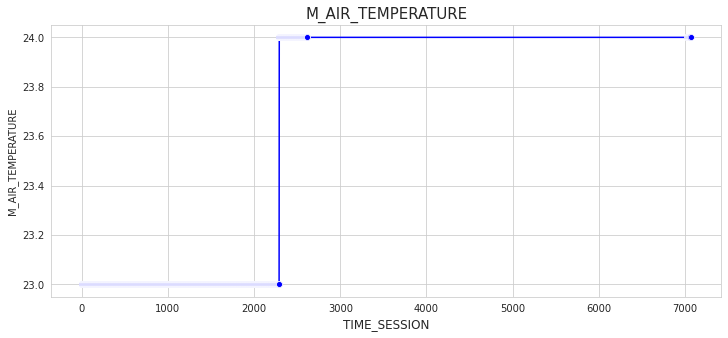

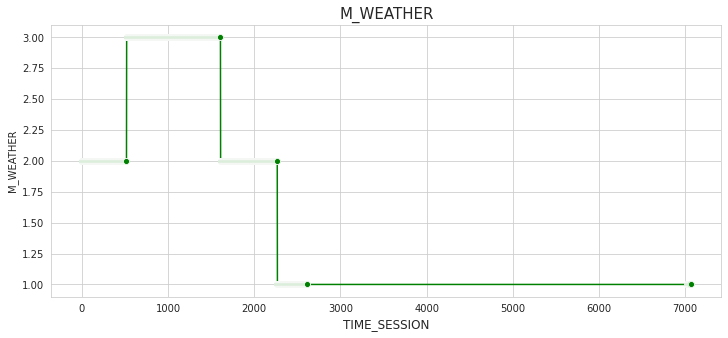

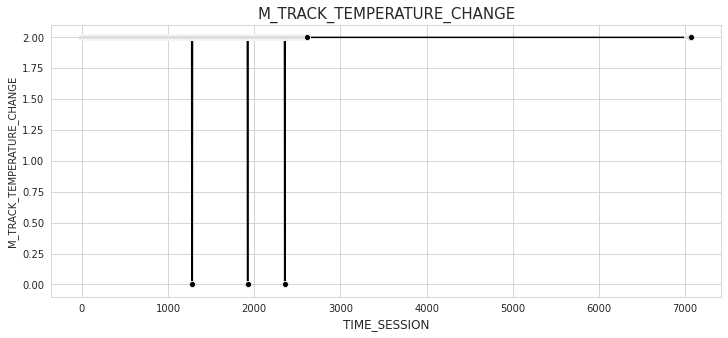

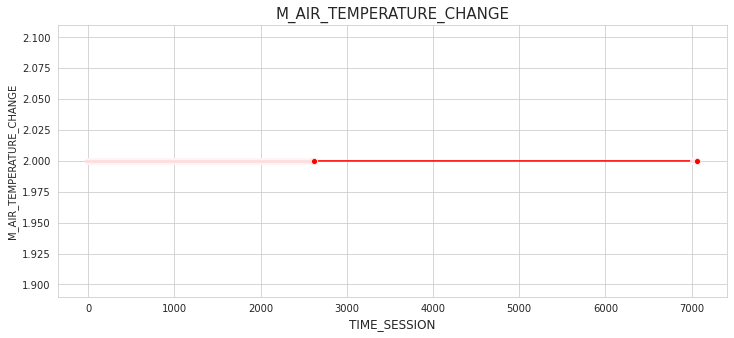

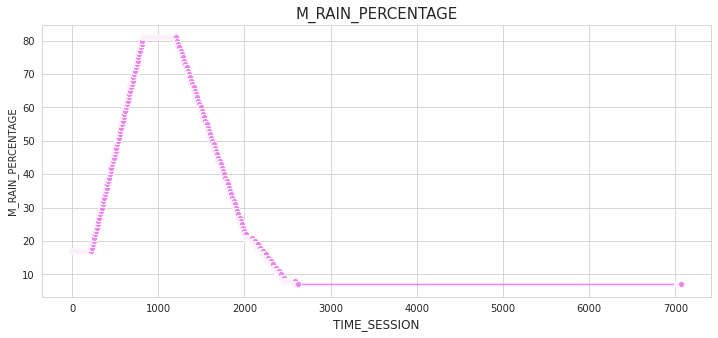

In [92]:
# Plotting Weather Data
color={2:'blue',
       3:'green',
       4:'black',
       5:'red',
       6:'violet',
       7:'brown'}
for index in range(2,7):
    plt.figure(figsize=(12,5))
    plt.xlabel('TIME_SESSION', fontsize=12)
    plt.title('{}'.format(weather_data_gt.columns[index].upper()), fontsize=15)
    sns.lineplot(data=weather_data_gt.iloc[:,index], marker='o',  color=color[index])
    plt.show()

### Ground truth correlation between features

In [81]:
# one-hot encode the features M_WEATHER
dummy1 = pd.get_dummies(weather_data['M_WEATHER'], drop_first=True)

In [82]:
weather_data = pd.concat([weather_data, dummy1], axis=1).drop("M_WEATHER", axis=1)

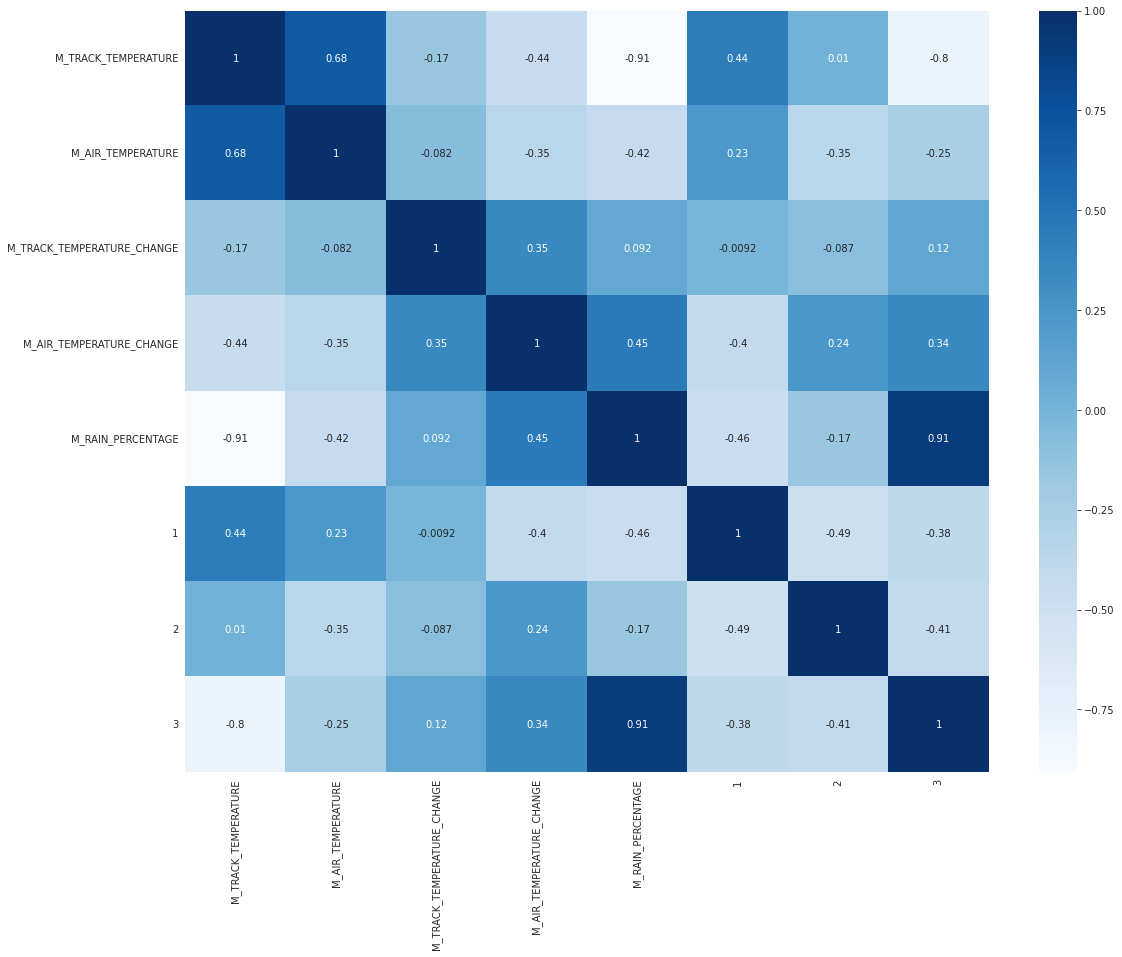

In [84]:
plt.figure(figsize=(18,14))
sns.heatmap(data=weather_data.corr(), annot=True, cmap='Blues')
plt.show()


In [93]:
indices = ['M_AIR_TEMPERATURE', 'M_TRACK_TEMPERATURE','M_RAIN_PERCENTAGE', 'M_WEATHER']
extr_data = weather_data_gt.loc[:,indices]
extr_data.head()

,M_AIR_TEMPERATURE,M_TRACK_TEMPERATURE,M_RAIN_PERCENTAGE,M_WEATHER
TIME_SESSION,,,,
7063,24,32,7,1
7062,24,32,7,1
7061,24,32,7,1
7060,24,32,7,1
7059,24,32,7,1


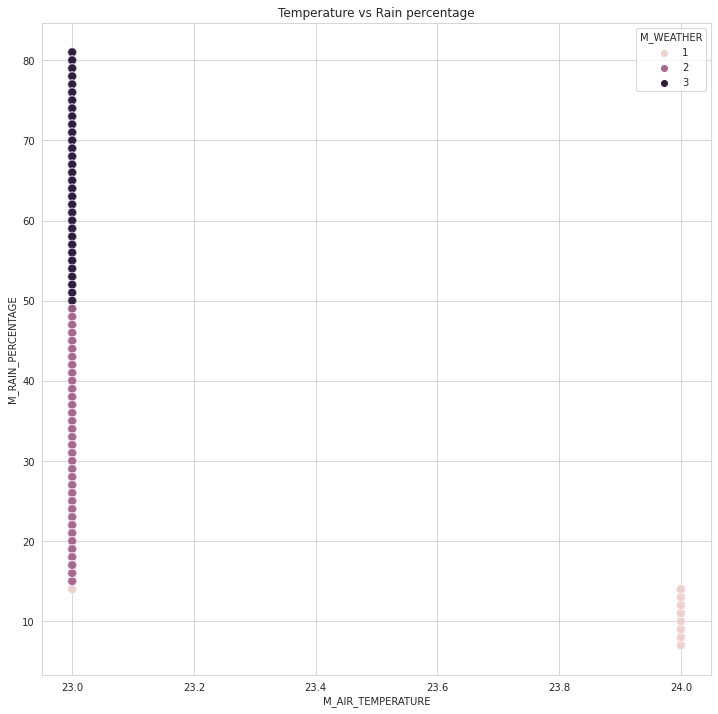

In [104]:
# Plot for Air temperature & Humidity by Summary
plt.figure(figsize=(12,12))
plt.title('Temperature vs Rain percentage')
sns.scatterplot(x=extr_data.iloc[:,0],
                y=extr_data.iloc[:,2],
                hue=extr_data.iloc[:,3],
                s=75,
                alpha=0.3)
plt.show()

 # 1 = light cloud, 2 = overcast
        # 3 = light rain

       M_AIR_TEMPERATURE  M_TRACK_TEMPERATURE  M_RAIN_PERCENTAGE    M_WEATHER
count        2658.000000          2658.000000        2658.000000  2658.000000
mean           23.138826            29.942814          42.924379     2.262603
std             0.345830             1.310521          26.077948     0.699132
min            23.000000            28.000000           7.000000     1.000000
25%            23.000000            29.000000          17.000000     2.000000
50%            23.000000            30.000000          40.000000     2.000000
75%            23.000000            31.000000          69.000000     3.000000
max            24.000000            32.000000          81.000000     3.000000


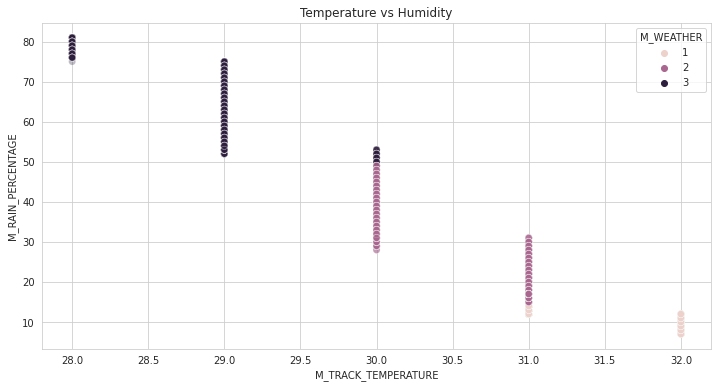

In [103]:
# Plot for Temperature & Rain % by weather class
plt.figure(figsize=(12,6))
print(extr_data.describe())
plt.title('Temperature vs Humidity')
sns.scatterplot(x=extr_data.iloc[:,1],
                y=extr_data.iloc[:,2],
                hue=extr_data.iloc[:,3],
                s=50,
                alpha=0.3)
plt.show()

### Data Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


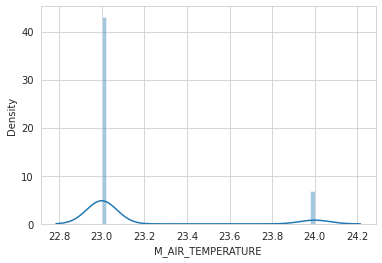

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


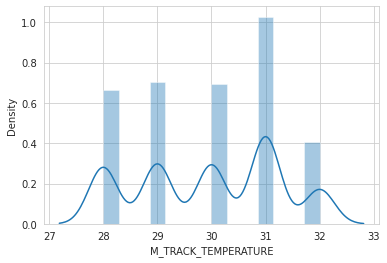

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


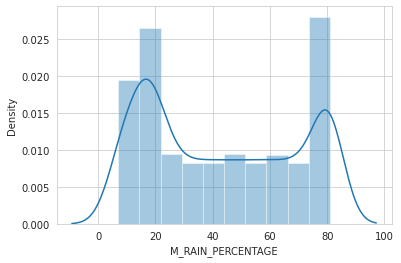

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


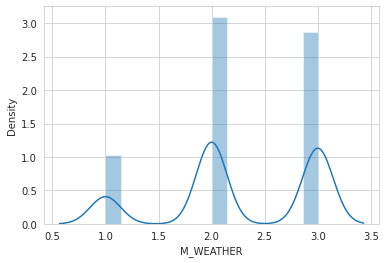

In [98]:
for ind in range(len(extr_data.columns)):
    sns.distplot(extr_data.iloc[:, ind])
    plt.show()

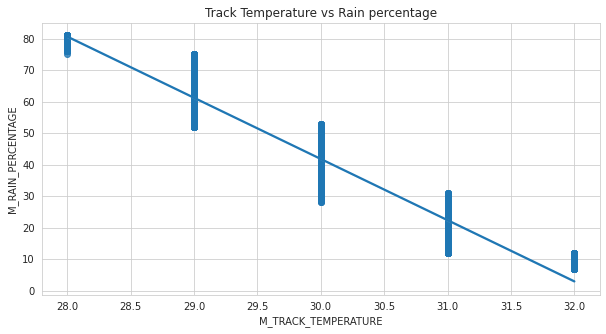

In [108]:
# Regression plot for Apparent Temperature & Humidity
plt.figure(figsize=(10,5))
plt.title('Track Temperature vs Rain percentage')
sns.regplot(x=extr_data.iloc[:,1],
            y=extr_data.iloc[:,2])
plt.show()